#**Unsupervised Learning (Clustering)**

In [ ]:
import pandas as pd

# Load the spam dataset
df = pd.read_csv('/content/spam.csv', encoding='latin-1')

# Optional cleanup: only keep relevant columns
df = df[['text', 'target']]
df['text'] = df['text'].astype(str)

df.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


#Step 1: TF-IDF Vectorization (no PCA yet)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(df['text'])

#Step 2: K-means and Hierarchical Clustering

In [ ]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Apply K-means
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_tfidf)

# Hierarchical clustering
Z = linkage(X_tfidf.toarray(), method='ward')
clusters_hier = fcluster(Z, 2, criterion='maxclust')

#Step 3: Plot Results

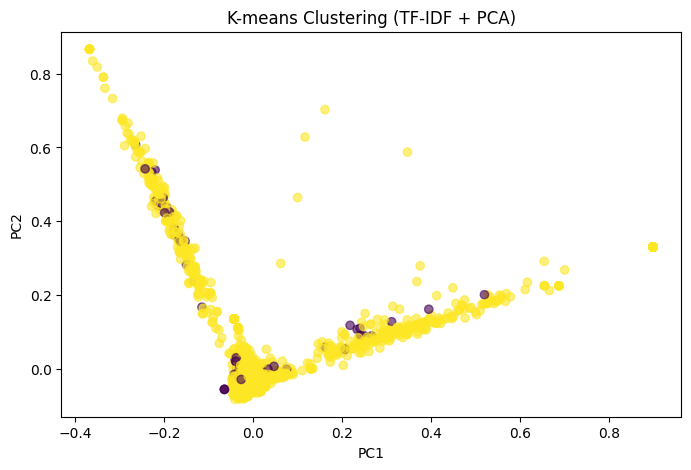

In [ ]:
# Plot by Clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.6)
plt.title('K-means Clustering (TF-IDF + PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

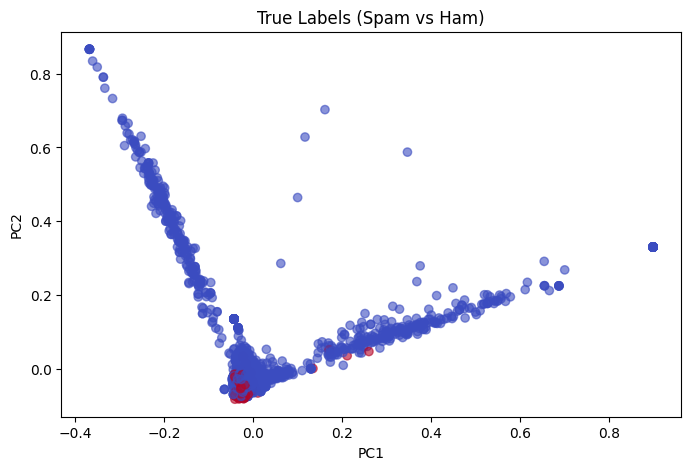

In [ ]:
# Plot by True Label
label_map = {'ham': 0, 'spam': 1}
labels = df['target'].map(label_map)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title('True Labels (Spam vs Ham)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#**Supervised Learning**

#step 1: Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('/content/spam.csv', encoding='latin-1')[['text', 'target']]
df['text'] = df['text'].astype(str)

In [ ]:
# Encode labels
df['label'] = LabelEncoder().fit_transform(df['target'])  # ham=0, spam=1

In [ ]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Step 2: Vectorize with Word2Vec

In [1]:
!pip install gensim

In [2]:
import gensim.downloader as api

# Load pre-trained Word2Vec vectors
w2v_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load and clean dataset
df = pd.read_csv('/content/spam.csv', encoding='latin-1')[['text', 'target']]
df['text'] = df['text'].astype(str)

# Encode labels (ham=0, spam=1)
df['label'] = LabelEncoder().fit_transform(df['target'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


In [7]:
X_train_vec = np.vstack([document_vector(doc) for doc in X_train])
X_test_vec = np.vstack([document_vector(doc) for doc in X_test])

#Step 2: Train & Evaluate Models

#A. Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf, target_names=['ham', 'spam']))


Random Forest Results:
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       965
        spam       0.98      0.66      0.79       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115



#B. XGBoost Classifier

In [11]:
!pip install xgboost

import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_vec, y_train)
y_pred_xgb = xgb_model.predict(X_test_vec)

print(" XGBoost Results:")
print(classification_report(y_test, y_pred_xgb, target_names=['ham', 'spam']))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 XGBoost Results:
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       965
        spam       0.94      0.79      0.86       150

    accuracy                           0.97      1115
   macro avg       0.95      0.89      0.92      1115
weighted avg       0.96      0.97      0.96      1115



#C. Naive Bayes (Best with TF-IDF)

In [13]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb, target_names=['ham', 'spam']))

Naive Bayes Results:
              precision    recall  f1-score   support

         ham       0.97      0.72      0.83       965
        spam       0.33      0.87      0.47       150

    accuracy                           0.74      1115
   macro avg       0.65      0.80      0.65      1115
weighted avg       0.89      0.74      0.78      1115



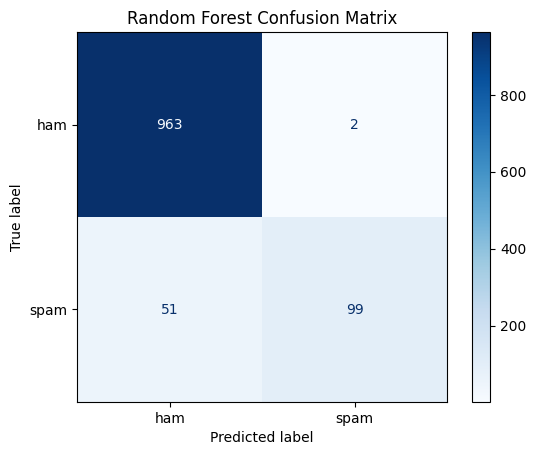

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()